# Baseline

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import os
import numpy as np
import pandas as pd
from fbprophet import Prophet

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from pandas_datareader import data as pdr

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [5]:
from mdp import TimeSeries
from mdp import MarketData
from mdp import MovingWindowFeatures
from mdp import ClassificationGenerator, RegressionGenerator, MultitaskGenerator
from mdp import invert_log_ret

import mdp.utils as utils
import mdp.plotHelpers as plotHelpers

In [6]:
import importlib

import mdp

importlib.reload(mdp)
importlib.reload(mdp.datasetGenerator)
importlib.reload(mdp.marketData)
importlib.reload(mdp.movingWindowFeatures)
importlib.reload(mdp.timeSeries)
importlib.reload(mdp.plotHelpers)
importlib.reload(mdp.utils);

# *Параметры*

In [7]:
INSTRUMENT = 'MSFT' # Microsoft corp
START_FROM = '2008-11-14'
END_DATE = '2020-01-01'
WINDOW_SIZE = 60
FORECAST_OFFSET=1
VAL_SPLIT = '2019-01-01'
TEST_SPLIT = '2019-06-01'

# *Исходные данные*

Загрузка данных и вычисление индикаторов.

In [8]:
instr = MarketData.create_from_tiingo(INSTRUMENT, start=START_FROM, end=END_DATE)

## Целевая переменная

Цена закрытия.

In [9]:
orig_target = instr.c

Переходим к логарифмической доходности.

In [10]:
def make_feature_selector():
    price_transformer = lambda: {'ratios': {}, 'ln': {}}
    diff_transformer = lambda o: {'diffs': {'order': o}}
    identity_transformer = lambda: {}
    feature_transformations = {
        'c': price_transformer(),
    }
    return feature_transformations

In [11]:
instr_transformed = instr.select_transform(make_feature_selector())

## Обучающая, валидационная и тестовая выборки

In [12]:
instr_train, instr_val_test = instr_transformed.train_test_split(VAL_SPLIT, window_size=WINDOW_SIZE,
                                                                 scaler=None)
#                                                                  scaler=MinMaxScaler,
#                                                                  scaler_kwargs={'feature_range': (-1, 1)})

instr_val, instr_test = instr_val_test.train_test_split(TEST_SPLIT, window_size=WINDOW_SIZE, scaler=None)

len(instr_train), len(instr_val), len(instr_test)

(2514, 164, 208)

# *Модели*

## Регрессия: случайное блуждание

Прогноз - следующее значение равно предыдущему, то есть прогнозируемая доходность - постоянная и равная 0.

In [13]:
pred_log_ret_test = np.zeros(len(instr_test) - WINDOW_SIZE)

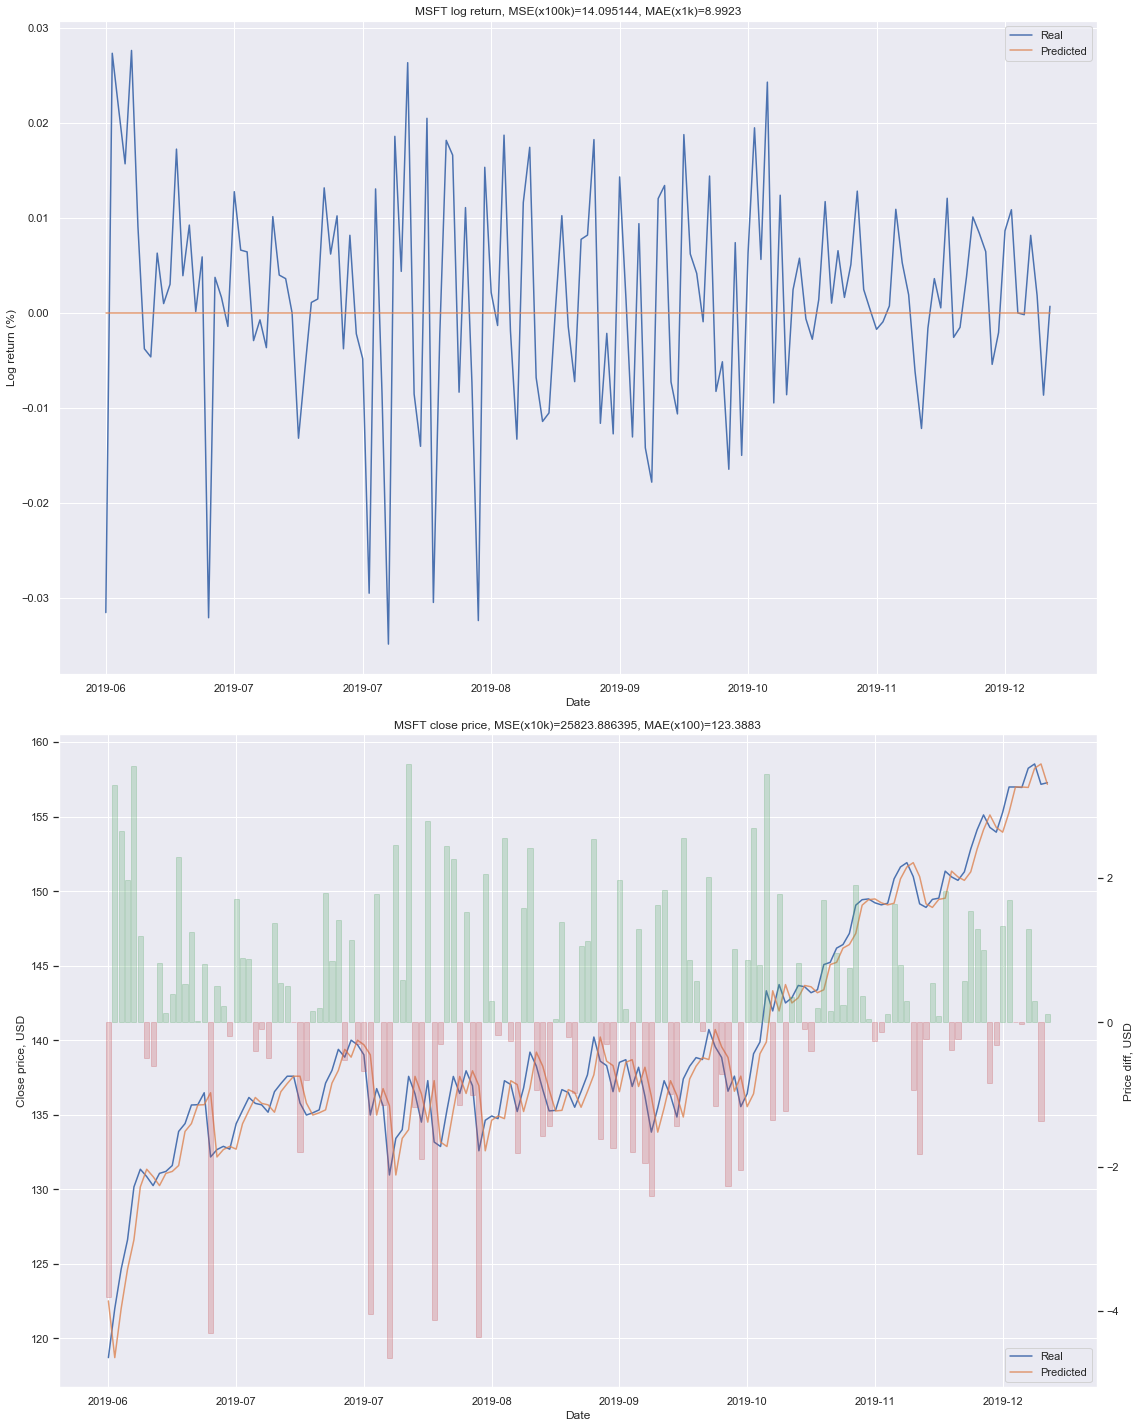

In [14]:
plotHelpers.plot_regr_predictions(orig_target, instr_test, pred_log_ret_test, figsize=(16, 20))

## Классификация: подбрасывание монеты

Метрики классификации в данном случае, очевидно, практического смысла не имеют: хотя в среднем ROC AUC будет равен 0.5, но в какой-то отдельной реализации он может случайно получиться относительно большой. Тем не менее для примера посчитаем метрики и здесь.

In [15]:
pred_direction_proba = np.random.uniform(size=len(instr_test))
predicted_direction = (0.5 < pred_direction_proba).astype(np.int)

true_direction = ClassificationGenerator.get_target_direction(instr_test.c[-len(pred_direction_proba):].data)

In [16]:
print(classification_report(true_direction, predicted_direction))

              precision    recall  f1-score   support

           0       0.31      0.31      0.31        83
           1       0.54      0.53      0.53       125

    accuracy                           0.44       208
   macro avg       0.42      0.42      0.42       208
weighted avg       0.44      0.44      0.44       208



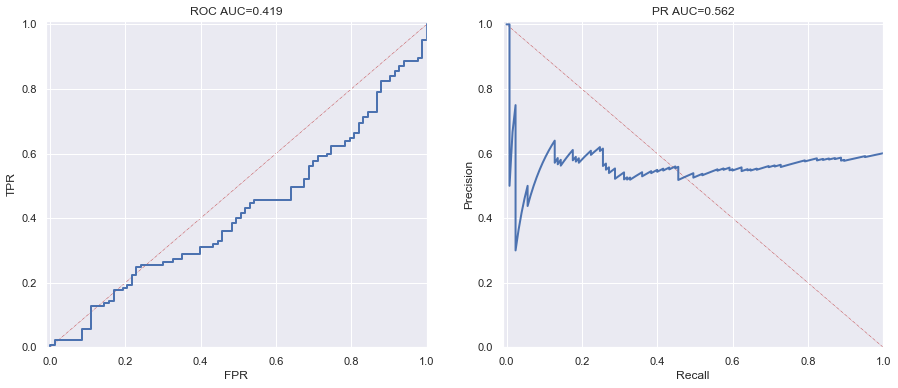

In [17]:
plotHelpers.plot_roc_pr_curves(true_direction, pred_direction_proba)

## [Prophet](https://facebook.github.io/prophet/docs/quick_start.html)

Также посмотрим прогноз, который может сделать аддитивная модель библиотеки [FB Prophet](https://facebook.github.io/prophet) "из коробки".

На вход принимает датафрейм заданного формата.

In [18]:
prophet_train = pd.DataFrame(instr_train.c.asSeries()).reset_index()

prophet_train.columns = ['ds', 'y']

prophet_train.tail()

,ds,y
2509,2018-12-24,-0.042635
2510,2018-12-26,0.066078
2511,2018-12-27,0.006147
2512,2018-12-28,-0.007839
2513,2018-12-31,0.011686


#### Обучение:

In [19]:
prophet = Prophet()

prophet.fit(prophet_train);

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Для сохранения результата прогноза также нужен датафрейм.

In [20]:
prophet_test = pd.DataFrame(instr_test.timestamps[WINDOW_SIZE:])

prophet_test.columns = ['ds']

prophet_test.head()

,ds
0,2019-06-03
1,2019-06-04
2,2019-06-05
3,2019-06-06
4,2019-06-07


#### Прогноз:

In [21]:
prophet_test = prophet.predict(prophet_test)

In [22]:
prophet_test.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
143,2019-12-24,0.002836,-0.019562,0.019774,0.002834,0.002839,-0.002542,-0.002542,-0.002542,-0.001570,-0.001570,-0.001570,-0.000973,-0.000973,-0.000973,0.0,0.0,0.0,0.000294
144,2019-12-26,0.002837,-0.020046,0.018066,0.002834,0.002840,-0.002931,-0.002931,-0.002931,-0.002022,-0.002022,-0.002022,-0.000909,-0.000909,-0.000909,0.0,0.0,0.0,-0.000094
145,2019-12-27,0.002837,-0.019752,0.019549,0.002834,0.002840,-0.002765,-0.002765,-0.002765,-0.001909,-0.001909,-0.001909,-0.000856,-0.000856,-0.000856,0.0,0.0,0.0,0.000072
146,2019-12-30,0.002837,-0.020477,0.020023,0.002834,0.002840,-0.002783,-0.002783,-0.002783,-0.002125,-0.002125,-0.002125,-0.000657,-0.000657,-0.000657,0.0,0.0,0.0,0.000054
147,2019-12-31,0.002837,-0.019516,0.019579,0.002835,0.002840,-0.002161,-0.002161,-0.002161,-0.001570,-0.001570,-0.001570,-0.000592,-0.000592,-0.000592,0.0,0.0,0.0,0.000676


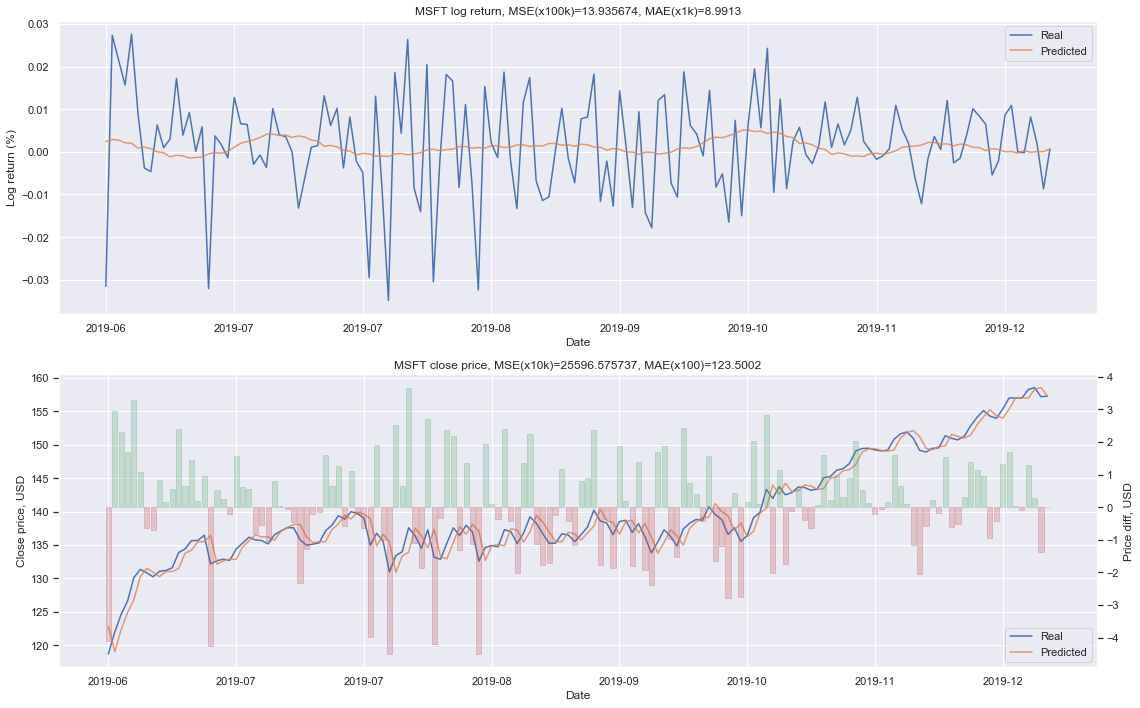

In [23]:
plotHelpers.plot_regr_predictions(orig_target, instr_test, prophet_test['yhat'].values, figsize=(16, 10))

Прогноз с доверительными интервалами:

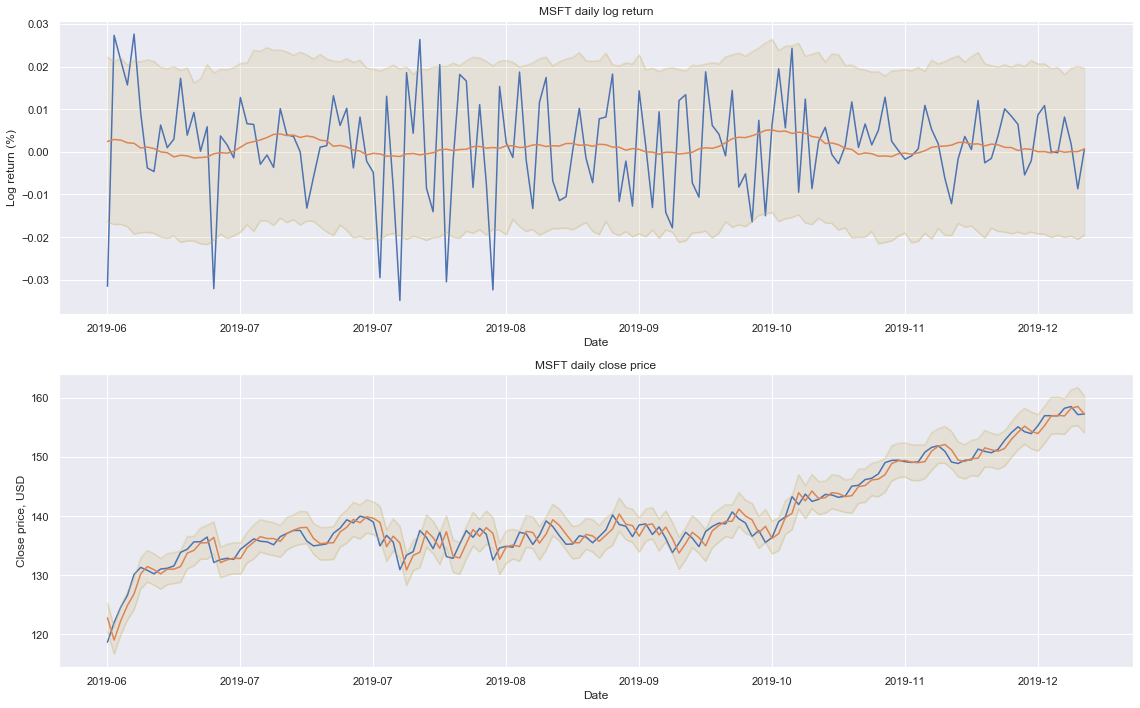

In [24]:
plotHelpers.plot_fbprohet_spread(orig_target, instr_test, prophet_test)

### Вывод

**Prophet** прогнозирует что-то близкое к модели случайного блуждания.